In [39]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch
from torch import nn
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image

In [42]:
model = torch.hub.load('ultralytics/yolov5', 'custom', '../../../../final/yolov5/best.pt')
print(model.model.model.model[-2])

Using cache found in /home/joo/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-5-17 Python-3.6.9 torch-1.10.1+cu102 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11011MiB)

Fusing layers... 


Python 3.7.0 required by YOLOv5, but Python 3.6.9 is currently installed


Model summary: 444 layers, 86173414 parameters, 0 gradients
Adding AutoShape... 


C3(
  (cv1): Conv(
    (conv): Conv2d(1280, 640, kernel_size=(1, 1), stride=(1, 1))
    (act): SiLU(inplace=True)
  )
  (cv2): Conv(
    (conv): Conv2d(1280, 640, kernel_size=(1, 1), stride=(1, 1))
    (act): SiLU(inplace=True)
  )
  (cv3): Conv(
    (conv): Conv2d(1280, 1280, kernel_size=(1, 1), stride=(1, 1))
    (act): SiLU(inplace=True)
  )
  (m): Sequential(
    (0): Bottleneck(
      (cv1): Conv(
        (conv): Conv2d(640, 640, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
    )
    (1): Bottleneck(
      (cv1): Conv(
        (conv): Conv2d(640, 640, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
    )
    (2): Bottleneck(
      (cv1)

In [41]:
target = model.model.model.model[-1]
print(target.m)

print("dir : "+str(dir(target.m))+"\n")

print("bias  : "+str(target.m[0].bias.shape)+"\n")

print("bias  : "+str(target.m[0].bias[2]))
print("weights : "+str(target.m[0].weight.shape)+"\n")

print("bias  : "+str(target.m[1].bias[2]))
print("weights : "+str(target.m[1].weight.shape)+"\n")

print("bias  : "+str(target.m[2].bias[2]))
print("weights : "+str(target.m[2].weight.shape)+"\n")

ModuleList(
  (0): Conv2d(320, 18, kernel_size=(1, 1), stride=(1, 1))
  (1): Conv2d(640, 18, kernel_size=(1, 1), stride=(1, 1))
  (2): Conv2d(1280, 18, kernel_size=(1, 1), stride=(1, 1))
)
dir : ['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_buffers', '_call_impl', '_forward_hooks', '_forward_pre_hooks', '_get_abs_string_index', '_get_backward_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_member

In [ ]:
COLORS = np.random.uniform(0, 255, size=(80, 3))

def parse_detections(results):
    detections = results.pandas().xyxy[0]
    detections = detections.to_dict()
    boxes, colors, names = [], [], []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0.2:
            continue
        xmin = int(detections["xmin"][i])
        ymin = int(detections["ymin"][i])
        xmax = int(detections["xmax"][i])
        ymax = int(detections["ymax"][i])
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names


def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color, 
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.eval()
model.cpu()

In [27]:
img = cv2.imread("/home/joo/Downloads/dog.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (640, 640))

rgb_img = img.copy()
print(f"rgb_img.shape : {rgb_img.shape}")

img = np.float32(img) / 255
print(f"np.float32/255 : {img.shape}")

transform = transforms.ToTensor()
tensor = transform(img).unsqueeze(0) # 차원 1 늘려줌!


target_layers = [model.model.model.model[-2]]
print(f"target_layers : {target_layers}")

results = model([rgb_img])
print(f"results : {results}")

rgb_img.shape : (640, 640, 3)
np.float32/255 : (640, 640, 3)
target_layers : [C3(
  (cv1): Conv(
    (conv): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (act): SiLU(inplace=True)
  )
  (cv2): Conv(
    (conv): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (act): SiLU(inplace=True)
  )
  (cv3): Conv(
    (conv): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
    (act): SiLU(inplace=True)
  )
  (m): Sequential(
    (0): Bottleneck(
      (cv1): Conv(
        (conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
    )
  )
)]
image 1/1: 640x640 5 dogs
Speed: 1.7ms pre-process, 114.7ms inference, 0.7ms NMS per image at shape (1, 3, 640, 640)
results : 


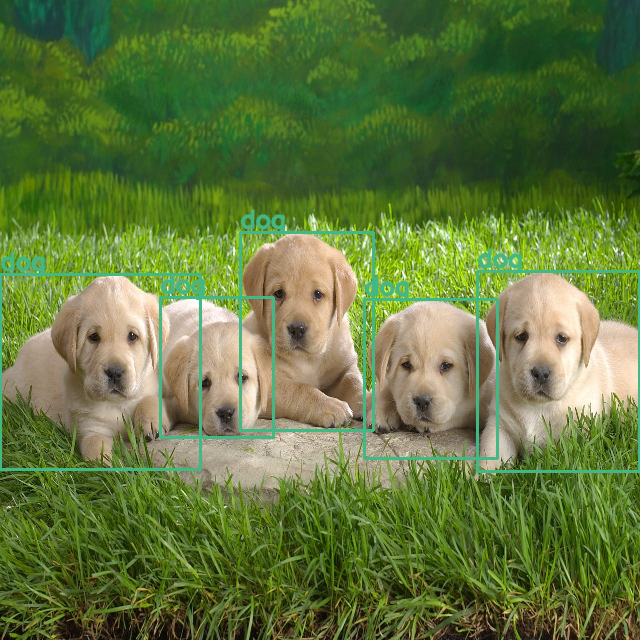

In [28]:
boxes, colors, names = parse_detections(results)
detections = draw_detections(boxes, colors, names, rgb_img.copy())
Image.fromarray(detections)

cam : (1, 640, 640)


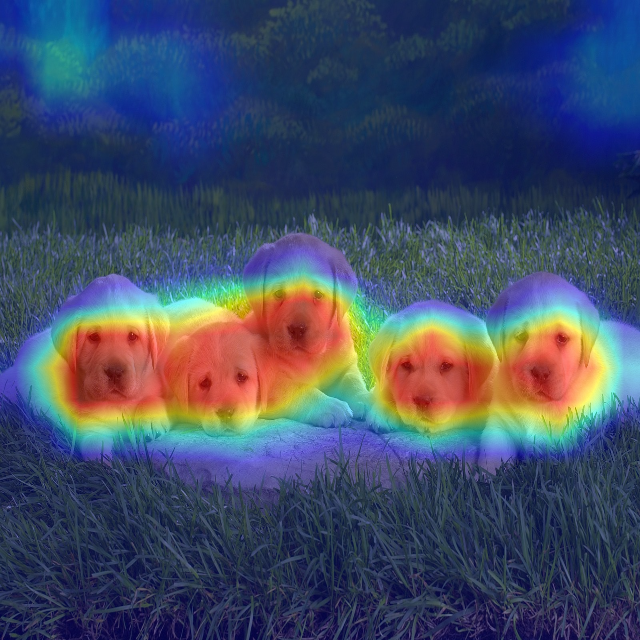

In [31]:
cam = EigenCAM(model, target_layers, use_cuda=False)
print(f"cam : {cam(tensor).shape}")
grayscale_cam = cam(tensor)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
Image.fromarray(cam_image)